In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
from torch.utils.data.dataset import Dataset
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [4]:
## 이미지에 가우스 노이즈를 추가하는 함수
def gaussian_noise(x, scale=0.8):
    # 가우스 노이즈를 더해줍니다.
    gaussian_data_x = x + np.random.normal(
        loc=0,
        scale=scale,
        size=x.shape
    )

    # 이미지의 픽셀값을 0과 1 사이로 정규화합니다.
    gaussian_data_x = np.clip(
        gaussian_data_x , 0, 1
    )

    gaussian_data_x = torch.tensor(gaussian_data_x) # 파이토치 텐서로 변환합니다.
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)

    return gaussian_data_x

## 데이터
# 학습용 데이터를 정의합니다.
training_data = MNIST(
    root="./",
    train=True,
    download=True,
    transform=ToTensor()
)

# 평가용 데이터를 정의합니다.
test_data = MNIST(
    root="./",
    train=False,
    download=True,
    transform=ToTensor()
)

## 헉습용 데이터 셋 만들 함수
class Denoising(Dataset):
    def __init__(self):
        # 원본 이미지를 담고 있는 MNIST 데이터
        self.mnist = MNIST(
            root="./",
            train=True,
            download=True,
            transform=ToTensor()
        )
        
        # 노이즈가 낀 데이터를 담는 리스트
        self.data = []

        # 노이지를 입힙니다.
        for i in range(len(self.mnist)):
            noisy_input = gaussian_noise(self.mnist.data[i])
            input_tensor = torch.tensor(noisy_input)
            self.data.append(torch.unsqueeze(input_tensor, dim=0)) # MNIST는 흑백 데이터라 채널 차원을 추가해 줬습니다.
    
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, i): # self: 입력 데이터는 노이즈가 낀 gaussian data
        data = self.data[i]

        # 원본 이미지도 0과 1 사이로 값을 맞춰줍니다.
        label = self.mnist.data[i]/255

        return data, label

In [6]:
## 기본 Block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim): # hidden_dim: 1번의 출려과 2번의 입력 사이 채널 수
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=hidden_dim,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_dim,out_channels=out_channels,kernel_size=3,padding=1)
        self.relu = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

## Encoder model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
        self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)

        return x

## Decoder model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim=8)
        self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)

        # 출력층을 기본 블록이 아닌 합성곱층을 사용합니다.
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

        # 업샘플링층
        self.upsample1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)
    
  
    # 인코더의 풀링 대신 입력 크기를 키우는 업샘플링 이용 합니다.
    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)

        return x

## Encoder와 Decoder를 사용해서 만든 Image Denoiser 모댈
class ImageDenoiser(nn.Module):
    def __init__(self):
        super(ImageDenoiser, self).__init__()
        
        self.enc = Encoder()
        self.dec = Decoder()
    
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x) # 채널 차원 삭제합니다.
        
        return x

In [8]:
## 학습
device = "cuda" if torch.cuda.is_available() else "cpu"

trainset = Denoising() # 학습에 이용할 데이터셋
train_loader = DataLoader(trainset, batch_size=32) # 한 번에 이미지 32장 사용합니다.

model = ImageDenoiser().to(device) # 디노이징에 사용할 오토인코더 모델

# 학습률과 최적화 정의 합니다.
lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)

for epoch in range(20):
    iterator = tqdm.tqdm(train_loader)

    for data, label in iterator:
        optim.zero_grad()
        pred = model(data.to(device))

        loss = nn.MSELoss()(torch.squeeze(pred), label.to(device)) # 손실 계산 합니다.
        loss.backward() # 오차 역전파
        optim.step() # 최적화
        iterator.set_description(f"epoch: {epoch+1}  loss: {loss.item()}")

torch.save(model.state_dict(), "./ImageDenoiser.pth") # 모델의 가중치 저장 합니다.

/var/folders/bn/t9c_7_2x6t3gqbxh70wc1_n40000gn/T/ipykernel_35335/1732591059.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x) # 파이토치 텐서로 변환합니다.
/var/folders/bn/t9c_7_2x6t3gqbxh70wc1_n40000gn/T/ipykernel_35335/1732591059.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch: 20  loss: 0.007407340686768293: 100%|███████████| 1875/1875 [4:46:37<00:00,  9.17s/it]


/var/folders/bn/t9c_7_2x6t3gqbxh70wc1_n40000gn/T/ipykernel_35335/1732591059.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x) # 파이토치 텐서로 변환합니다.


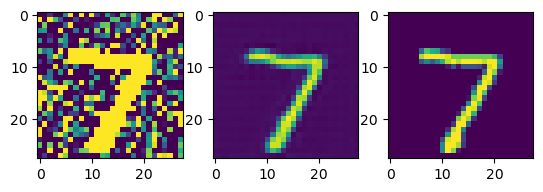

In [9]:
## 평가
model.cpu() # 모델의 출력값을 cpu로 이동 합니다.

with torch.no_grad():
    model.load_state_dict(torch.load("./ImageDenoiser.pth", map_location=device))

    img = test_data.data[0] # 시각화에 사용할 이미지 한 장을 불러옵니다.
    gaussian = gaussian_noise(img) # 이미지에 가우스 노이즈를 입힙니다.
    
    input = torch.unsqueeze(gaussian, dim=0) # 모델의 입력 모양에 맞춰 채널 차원 추가 합니다.
    input.type(torch.FloatTensor) # 가중치와 입력의 데이터 타입을 맞춤니다.
    input.to(device)
    input = torch.unsqueeze(input, dim=0) # 배치 크기 1을 위한 배치 차원 추가 합니다.

    plt.subplot(1, 3, 1)
    plt.imshow(torch.squeeze(gaussian))
    plt.subplot(1, 3, 2)
    plt.imshow(torch.squeeze(model(input)))
    plt.subplot(1, 3, 3)
    plt.imshow(torch.squeeze(torch.squeeze(img)))
    plt.show()